## Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [4]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


## Preprocessing

In [5]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [6]:
train_traj_key = 'kukatraj1'
test_traj_key = 'kukatraj2'

train_data = trajectories[train_traj_key]
test_data = trajectories[test_traj_key]

# Inputs: joint positions (7), velocities (7), torques (7)
X_train = train_data[:, :21]
# Targets: next joint positions (7), next joint velocities (7)
y_train = train_data[:, 21:]

X_test = test_data[:, :21]
y_test = test_data[:, 21:]

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")
print(f"Number of input features: {X_train.shape[1]}")
print(f"Number of output targets: {y_train.shape[1]}")

Number of training samples: 1814
Number of testing samples: 1857
Number of input features: 21
Number of output targets: 14


# In-depth Evaluation
---

In [ ]:
import time
import torch

overall_start_time = time.time()
#trajectories = load_data()
#if trajectories is None: return
trajectory_keys = sorted(list(trajectories.keys()))

# Hyperparameters from pc-esn++ implementation
N_RESERVOIR = 40
SPECTRAL_RADIUS = 1.2
SPARSITY = 0.9
LEAK_RATE = 0.25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla T4
Trajectories: 10
---------------------------------


In [ ]:
import sys
sys.path.append('../pc_esn')

import model
import utils

fold_results = []

model = model.PC_ESN(n_inputs=21, n_outputs=14, n_reservoir=N_RESERVOIR,
                   spectral_radius=SPECTRAL_RADIUS, sparsity=SPARSITY,
                   leak_rate=LEAK_RATE, device=device)

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)

    train_time_start = time.time()
    model.train(X_train_t, y_train_t)
    training_time = time.time() - train_time_start
    print(f"Training complete in {training_time:.2f} seconds.")

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = model.predict_step_by_step(X_test_t)

    # Scenario B: Full trajectory prediction
    y_pred_full = model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = utils.nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)

    fold_results.append(current_fold_results)
    print(f"Fold {i+1} evaluation complete. Total time: {time.time() - fold_start_time:.2f}s")

    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Training complete in 103.68 seconds.
Fold 1 evaluation complete. Total time: 104.79s

--- Fold 2/10 ---
Testing on: kukatraj10
Training complete in 101.92 seconds.
Fold 2 evaluation complete. Total time: 102.84s

--- Fold 3/10 ---
Testing on: kukatraj2
Training complete in 103.25 seconds.
Fold 3 evaluation complete. Total time: 104.18s

--- Fold 4/10 ---
Testing on: kukatraj3
Training complete in 102.60 seconds.
Fold 4 evaluation complete. Total time: 103.53s

--- Fold 5/10 ---
Testing on: kukatraj4
Training complete in 102.40 seconds.
Fold 5 evaluation complete. Total time: 103.31s

--- Fold 6/10 ---
Testing on: kukatraj5
Training complete in 101.26 seconds.
Fold 6 evaluation complete. Total time: 102.13s

--- Fold 7/10 ---
Testing on: kukatraj6
Training complete in 100.36 seconds.
Fold 7 evaluation complete. Total time: 101.30s

--- Fold 8/10 ---
Testing on: kukatraj7
Training complete in 100.24 seconds.
Fold 8 evaluation complete. Total time:

In [9]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")
print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 17.26 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 101.29 ± 1.99
Step-by-Step Pos nMSE       | 1.4186 ± 0.4217
Step-by-Step Vel nMSE       | 3.9780 ± 1.2177
Step-by-Step Euclid Err (m) | 0.7882 ± 0.1218
Full Traj Pos nMSE          | 1.5239 ± 0.4785
Full Traj Vel nMSE          | 4.3106 ± 1.3291
Full Traj Euclid Err (m) | 0.4078 ± 0.0732
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 52291497218.3153 ± 60882535985.3542      | 0.1653 ± 0.0310
200     | 16443741373.9390 ± 29867606964.9495      | 0.1531 ± 0.0356
500     | 269.1245 ± 630.0248      | 0.2925 ± 0.0696
1000    | 2.0757 ± 1.0319 

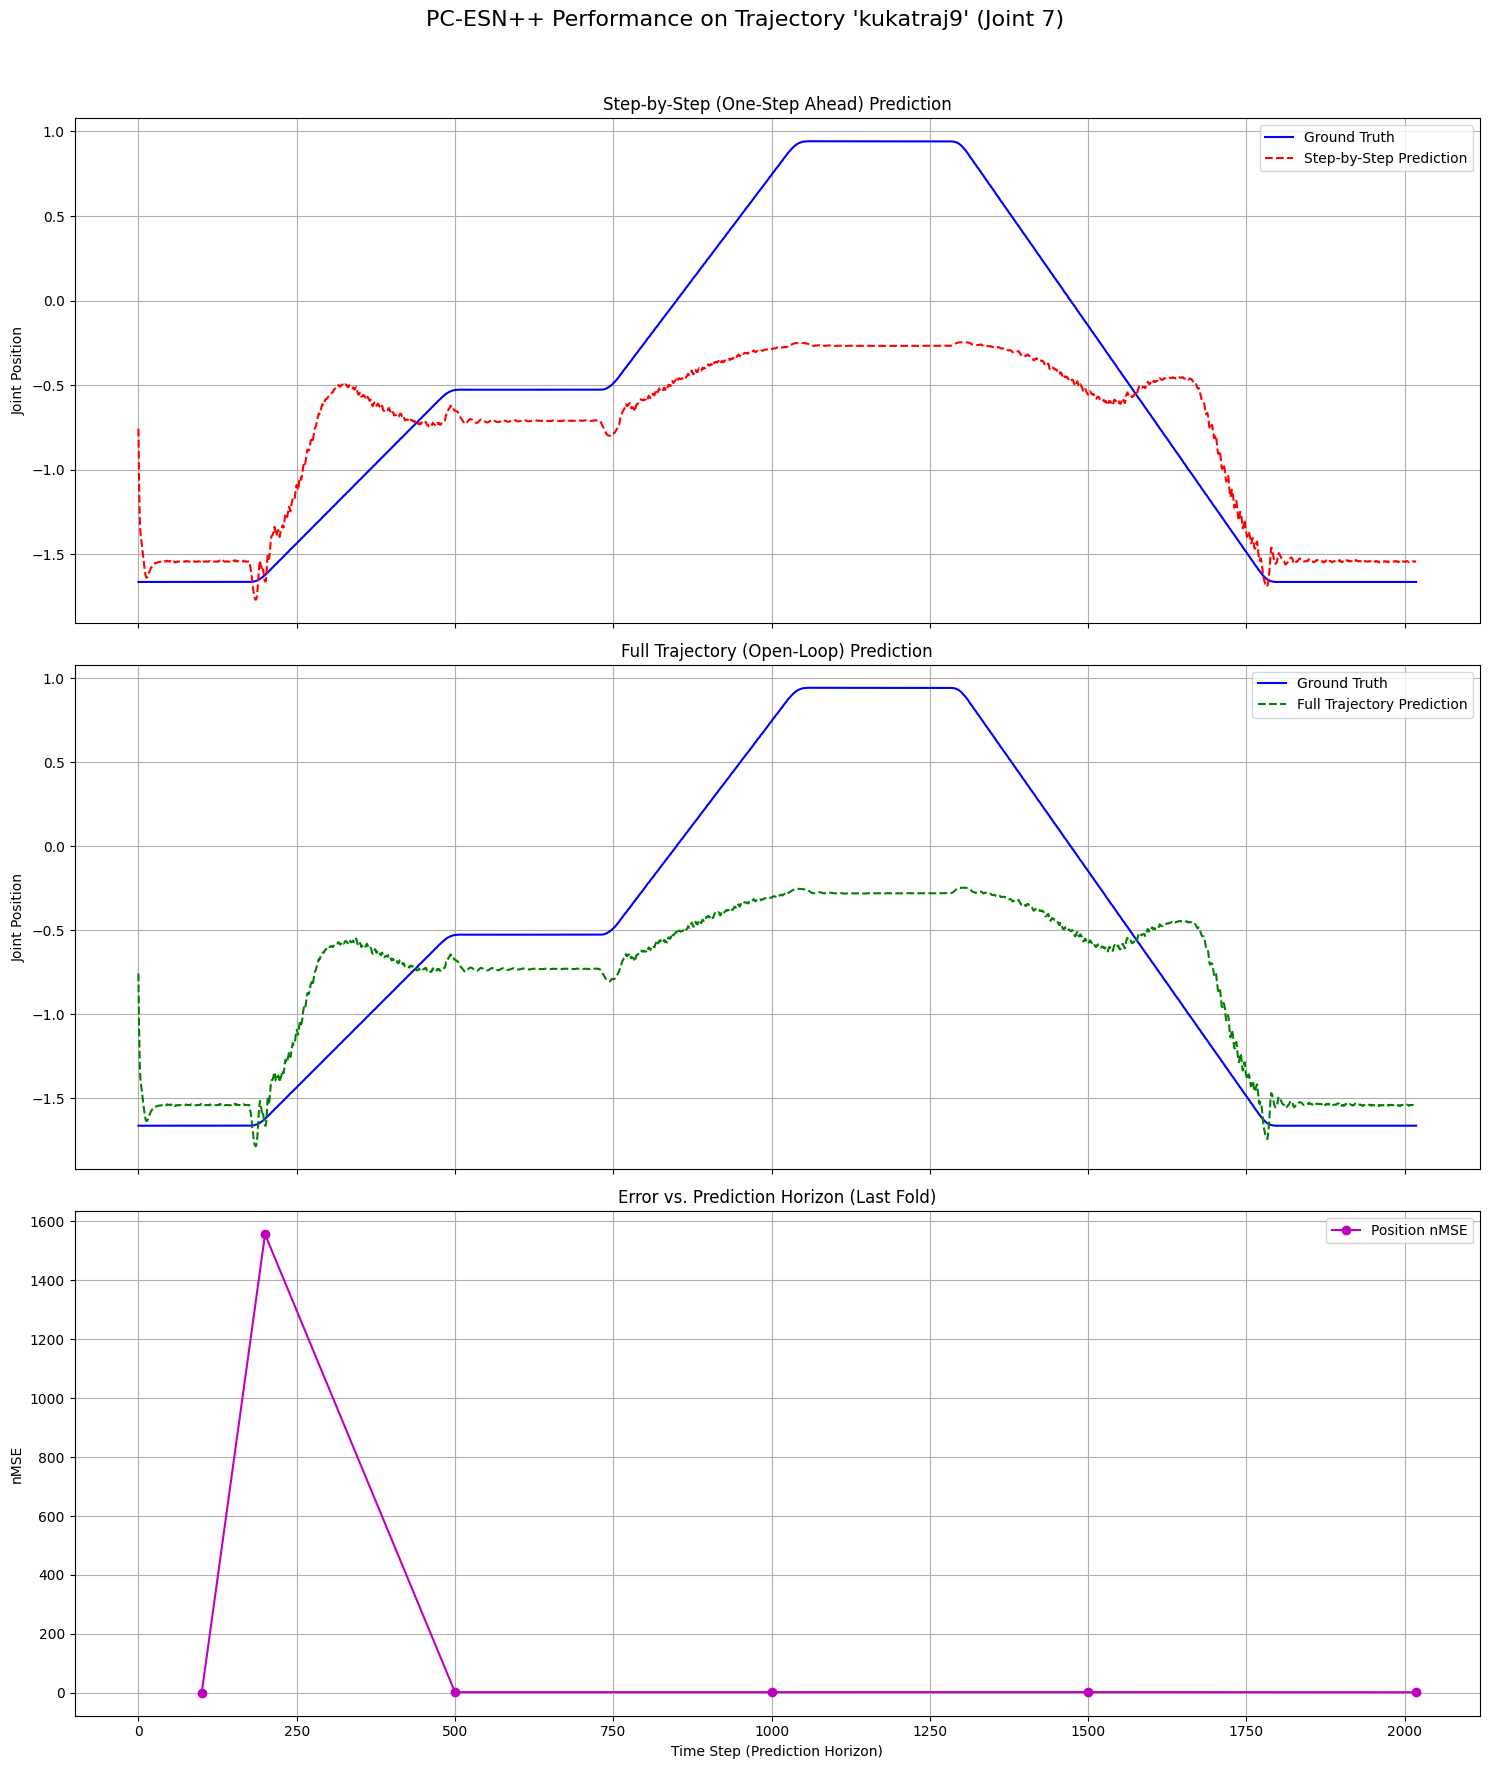

In [10]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
from scipy import stats

# --- Statistical Significance Test (Example) ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -6.0445, P-value: 0.0002
The difference is statistically significant (p < 0.05).


(np.float64(-0.01605450958013535),
 np.float64(1.5990586563944817),
 np.float64(-0.46108633279800415),
 np.float64(0.5682137608528137))

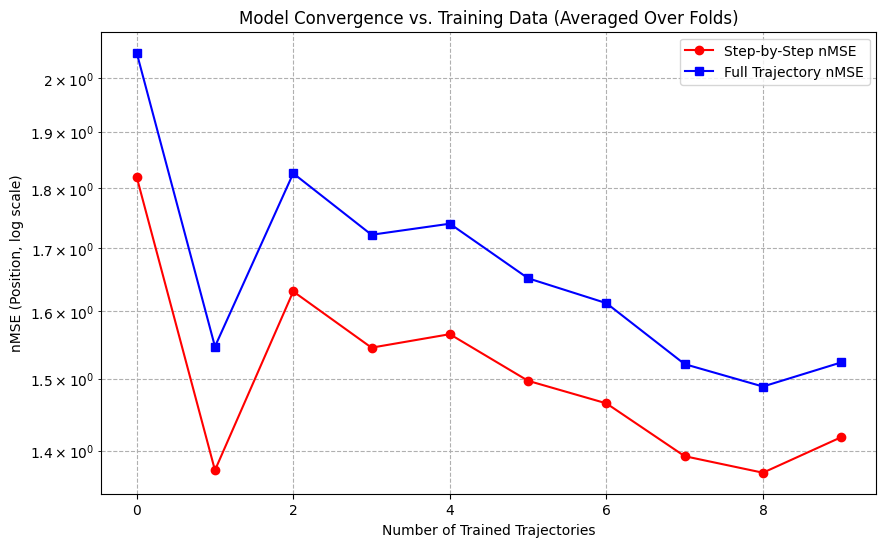

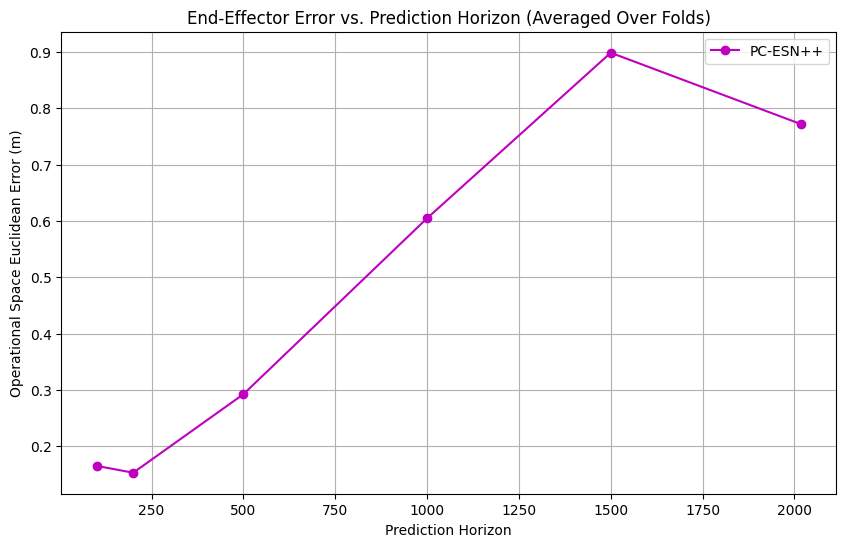

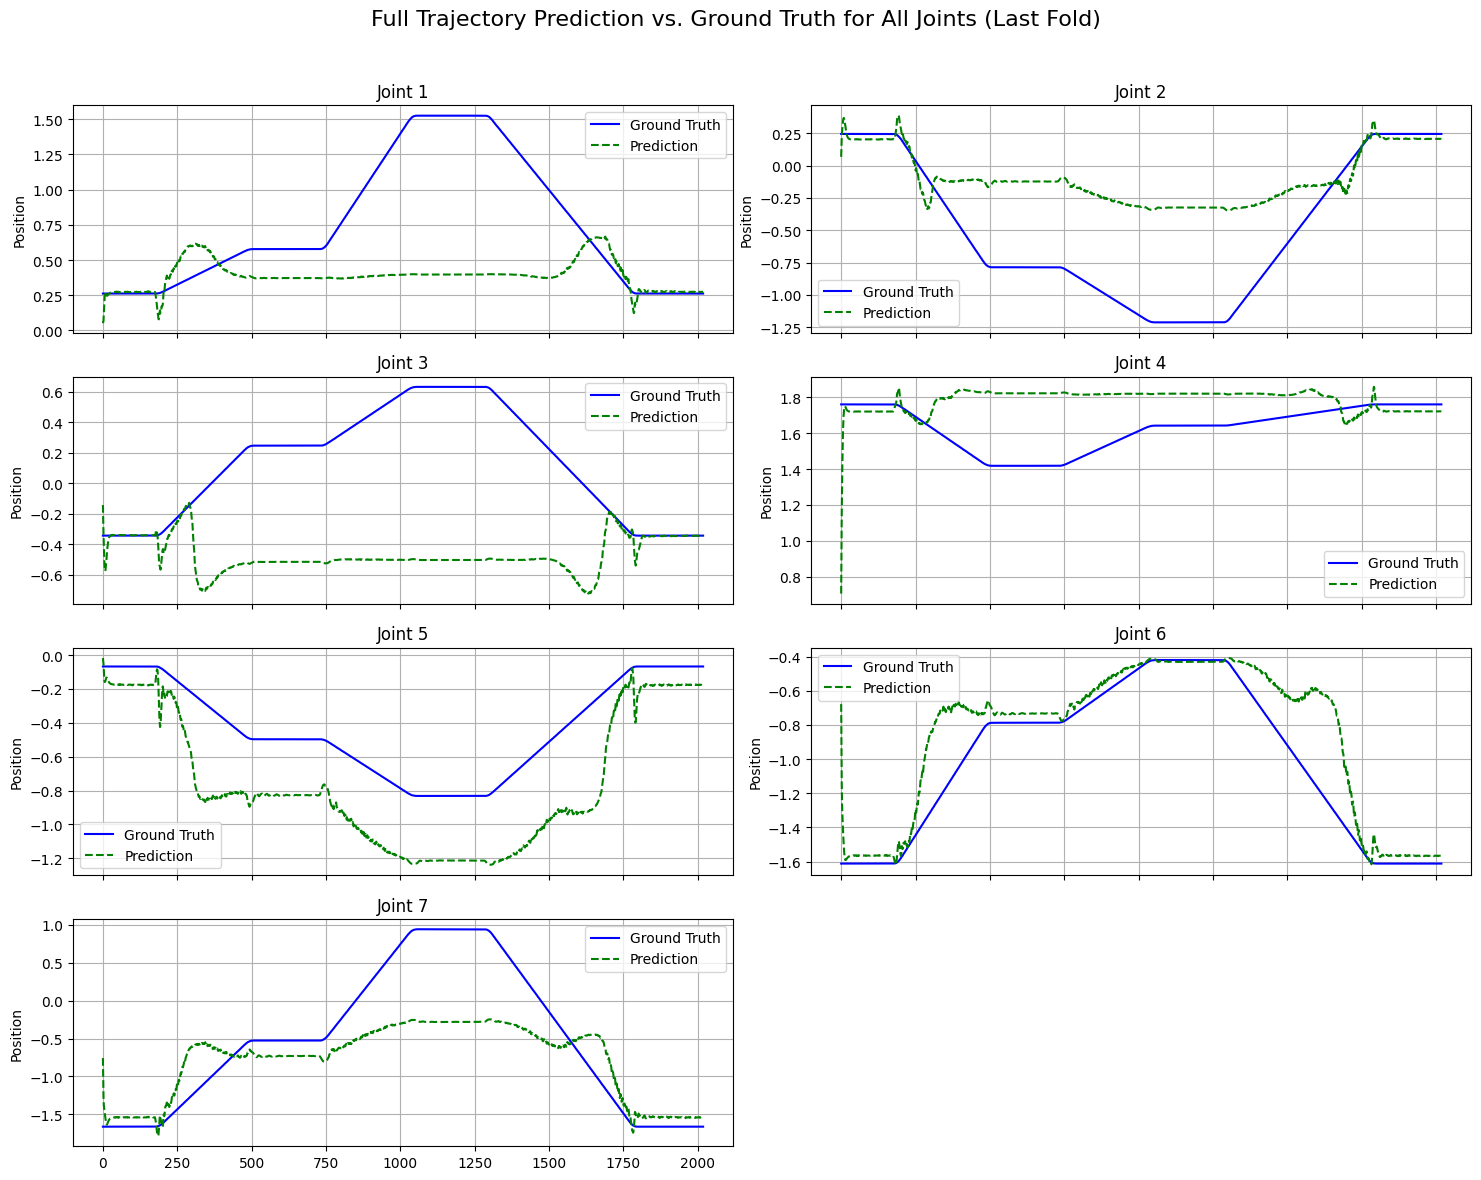

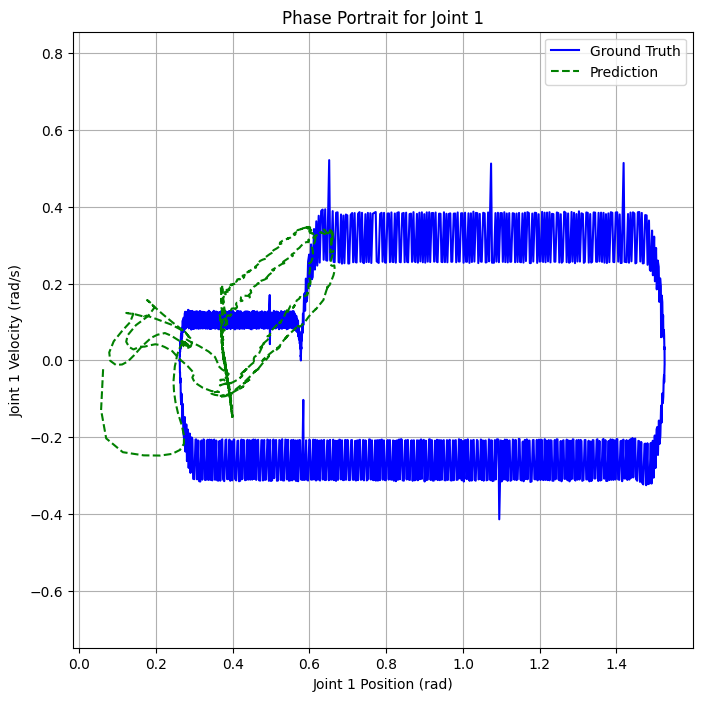

In [12]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')